# 1D CNN Segmentation - Insole(vGRF) to 3D-GRFM

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2025-03-08 01:06:02.651145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 01:06:02.710927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741385162.749517  286911 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741385162.760013  286911 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 01:06:02.812464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libraries

In [3]:
import os
import re
import h5py
import scipy
import random
import pickle
import json
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
from scipy import stats, signal
%matplotlib inline
sns.set_style('white')
from models import *
from models.unet_variants import *
from models.MLMRSNet import *

# Global Configurations

In [4]:
task_num = 1
start_fold = 1
end_fold = 5
target_quantity = 'CoPz'
body_side = 'RL'
movement_type = 'combined_insole_FP'
FP_Channel_Info = ['Fx','Fy','Fz','Mx','My','Mz','CoPx','CoPy','CoPz']
Insole_Channel_Info = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12','p13','p14','p15','p16','acc1','acc2','acc3','ang1','ang2','ang3','Fy','CoPx','CoPy']
weight_array = [75.2,65.1,56.0,80.8,61.5,81.0,61.6,62.4,69.0]
print(FP_Channel_Info)
print(weight_array)

['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'CoPx', 'CoPy', 'CoPz']
[75.2, 65.1, 56.0, 80.8, 61.5, 81.0, 61.6, 62.4, 69.0]


# Import and Prepare Data

Load File and Extract

In [ ]:
# Import
fl_Data_Walk = h5py.File(os.path.join('Data_Preprocessed_Walk.mat'), 'r')
fl_Data_Run = h5py.File(os.path.join('Data_Preprocessed_Run.mat'), 'r')
print(fl_Data_Walk.keys())
# Left Leg (LL) Insole VGRF Data per sensor
X_Data_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_LL']),0,2)
X_Data_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_LL']),0,2)
X_Data_LL = np.concatenate((X_Data_LL_Walk, X_Data_LL_Run), axis=0)
X_Data_Labels = np.array(fl_Data_Walk['label_Insole'])
print(X_Data_LL.shape)
# Right Leg (RL) Insole VGRF Data per sensor
X_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
X_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
X_Data_RL = np.concatenate((Y_Data_RL_Walk, Y_Data_RL_Run), axis=0)
print(X_Data_RL.shape)
# Left Leg (LL) CoP Data
Y_Data_LL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_LL']),0,2)
Y_Data_LL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_LL']),0,2)
Y_Data_LL = np.concatenate((Y_Data_LL_Walk, Y_Data_LL_Run), axis=0)
print(Y_Data_LL.shape)
# Right Leg (RL) CoP Data
Y_Data_RL_Walk = np.swapaxes(np.array(fl_Data_Walk['data_Insole_RL']),0,2)
Y_Data_RL_Run = np.swapaxes(np.array(fl_Data_Run['data_Insole_RL']),0,2)
Y_Data_RL = np.concatenate((X_Data_RL_Walk, X_Data_RL_Run), axis=0)
print(Y_Data_RL.shape)
Y_Label_sub_Walk = np.swapaxes(np.array(fl_Data_Walk['subinfo']),0,1)
Y_Label_sub_Run = np.swapaxes(np.array(fl_Data_Run['subinfo']),0,1)
Y_Label_sub = np.concatenate((Y_Label_sub_Walk, Y_Label_sub_Run), axis=0)
print(Y_Label_sub.shape)
Y_Label_speed_Walk = np.swapaxes(np.array(fl_Data_Walk['speedinfo']),0,1)
Y_Label_speed_Run = np.swapaxes(np.array(fl_Data_Run['speedinfo']),0,1)
Y_Label_speed = np.concatenate((Y_Label_speed_Walk, Y_Label_speed_Run), axis=0)
print(Y_Label_speed.shape)
Y_Label_LL_mode_Walk = np.zeros((Y_Data_LL_Walk.shape[0],1), dtype=int)
Y_Label_LL_mode_Run = np.ones((Y_Data_LL_Run.shape[0],1), dtype=int)
Y_Label_LL_mode = np.concatenate((Y_Label_LL_mode_Walk, Y_Label_LL_mode_Run), axis=0)
print(Y_Label_LL_mode.shape)
print(np.unique(Y_Label_LL_mode))
Y_Label_RL_mode_Walk = np.zeros((Y_Data_RL_Walk.shape[0],1), dtype=int)
Y_Label_RL_mode_Run = np.ones((Y_Data_RL_Run.shape[0],1), dtype=int)
Y_Label_RL_mode = np.concatenate((Y_Label_RL_mode_Walk, Y_Label_RL_mode_Run), axis=0)
print(Y_Label_RL_mode.shape)
print(np.unique(Y_Label_RL_mode))
# Check for NaNs and InFs
data = pd.Series(X_Data_LL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(X_Data_RL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data_LL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
data = pd.Series(Y_Data_RL.ravel())
print(data.isna().any())
print(data.isin([np.inf, -np.inf]).any())
del fl_Data_Walk, fl_Data_Run, X_Data_LL_Walk, X_Data_LL_Run, X_Data_RL_Walk, X_Data_RL_Run, Y_Data_LL_Walk, Y_Data_LL_Run, Y_Data_RL_Walk, Y_Data_RL_Run
del Y_Label_sub_Walk, Y_Label_sub_Run, Y_Label_speed_Walk, Y_Label_speed_Run, Y_Label_LL_mode_Walk, Y_Label_LL_mode_Run, Y_Label_RL_mode_Walk, Y_Label_RL_mode_Run

<KeysViewHDF5 ['#refs#', '#subsystem#', 'data_CoM', 'data_EMG', 'data_Force_FP_LL', 'data_Force_FP_RL', 'data_IMU', 'data_Insole_LL', 'data_Insole_RL', 'label_EMG', 'label_FP', 'label_IMU', 'label_Insole', 'speedinfo', 'subinfo']>


Select Task (Right or Left foot)

In [ ]:
if body_side == 'RL':
    X_Data = X_Data_RL
    Y_Data = Y_Data_RL
    Y_Label_mode = Y_Label_RL_mode
elif body_side == 'LL':
    X_Data = X_Data_LL
    Y_Data = Y_Data_LL
    Y_Label_mode = Y_Label_LL_mode
X_Data = X_Data[:,:,0:16]
if target_quantity == 'CoPx':
    Y_Data = np.expand_dims(Y_Data[:,:,23], axis=2)
elif target_quantity == 'CoPz':
    Y_Data = np.expand_dims(Y_Data[:,:,24], axis=2)
print(X_Data.shape)
print(Y_Data.shape)
print(Y_Label_mode.shape)

(4737, 1024, 16)
(4737, 1024, 1)
(4737, 1)


Select Channels (Optional)

In [ ]:
# Remove Low Correlated Insole Channels
print(X_Data.shape)
sample_num = X_Data.shape[0]
segment_length = X_Data.shape[1]
num_channels = X_Data.shape[2]
X_Data_Pruned = np.zeros((sample_num,segment_length,num_channels))
Insole_Channels_Selected = []
counter = 0
for i in range(0,num_channels):
    data_current_channel = X_Data[:,:,i]
    data_current_channel_pcc, _ = stats.pearsonr(data_current_channel.ravel(), Y_Data.ravel())
    data_current_channel_cos = np.dot(data_current_channel.ravel(),Y_Data.ravel())/(np.linalg.norm(data_current_channel.ravel())*np.linalg.norm(Y_Data.ravel()))
    data_current_channel_rr = r2_score(data_current_channel.ravel(), Y_Data.ravel())
    data_current_channel_var = np.var(data_current_channel.ravel())
    if (data_current_channel_var > 0):
        # if (data_current_channel_pcc > 0.05) and (data_current_channel_cos > 0.3):
        if (np.abs(data_current_channel_pcc) > 0.1):
            X_Data_Pruned[:,:,counter] = data_current_channel
            Insole_Channels_Selected.append(Insole_Channel_Info[i])
            print(Insole_Channel_Info[i])
            print(data_current_channel_pcc)
            # print(data_current_channel_cos)
            # print(data_current_channel_rr)
            counter = counter + 1
X_Data_Pruned = X_Data_Pruned[:,:,0:counter]
X_Data_Shape = X_Data_Pruned.shape
num_channels = X_Data_Shape[2]
print(X_Data_Shape)
print(Insole_Channels_Selected)

In [ ]:
## Remove highly intercorrelated channels
# Convert Arrays to Python Dictionaries
X_Data_Feature_List = Insole_Channels_Selected
X_Data_Array = np.reshape(X_Data_Pruned,(X_Data_Pruned.shape[0]*X_Data_Pruned.shape[1],X_Data_Pruned.shape[2]))
X_Data_Dict = pd.DataFrame(X_Data_Array,columns=X_Data_Feature_List)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_Data_Dict.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_Data_Dict.columns.values]
# Prune channels based on PCC
thresh = 0.9  # VIF = 10
vif_thresh = 10
cor_matrix = X_Data_Dict.corr().abs()
vif_matrix = 1/(1-cor_matrix)
vif_array = np.array(vif_matrix).flatten()
vif_array[~np.isfinite(vif_array)] = 0
upper_tri = vif_matrix.where(np.triu(np.ones(vif_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > vif_thresh)]
X_Data_Updated_Dict = X_Data_Dict.drop(to_drop, axis=1)
X_Data_Updated = np.reshape(X_Data_Updated_Dict, (X_Data_Pruned.shape[0],X_Data_Pruned.shape[1],X_Data_Updated_Dict.shape[1]))
print(X_Data_Updated.shape)
insole_sensors_Final = [x for x in X_Data_Dict.columns if x not in to_drop]
print(insole_sensors_Final)

# Plot Cross-correlation Heatmap
plt.subplots(figsize=(14, 12))
low_tri_matrix = np.triu(1/(1-X_Data_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Dict.corr()), vmin=0, vmax=np.max(vif_array), annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='YlOrBr', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
X_Data = X_Data_Updated
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(8, 6))
low_tri_matrix = np.triu(1/(1-X_Data_Updated_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Updated_Dict.corr()), vmin=0, vmax=vif_thresh, annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
# res.xaxis.tick_top()
X_Data = X_Data_Updated

In [ ]:
## Remove highly intercorrelated channels
# Convert Arrays to Python Dictionaries
X_Data_Feature_List = Insole_Channels_Selected
X_Data_Array = np.reshape(X_Data_Pruned,(X_Data_Pruned.shape[0]*X_Data_Pruned.shape[1],X_Data_Pruned.shape[2]))
X_Data_Dict = pd.DataFrame(X_Data_Array,columns=X_Data_Feature_List)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_Data_Dict.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_Data_Dict.columns.values]
# Prune channels based on PCC
thresh = 0.9  # VIF = 10
vif_thresh = 10
cor_matrix = X_Data_Dict.corr().abs()
vif_matrix = 1/(1-cor_matrix)
vif_array = np.array(vif_matrix).flatten()
vif_array[~np.isfinite(vif_array)] = 0
upper_tri = vif_matrix.where(np.triu(np.ones(vif_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > vif_thresh)]
X_Data_Updated_Dict = X_Data_Dict.drop(to_drop, axis=1)
X_Data_Updated = np.reshape(X_Data_Updated_Dict, (X_Data_Pruned.shape[0],X_Data_Pruned.shape[1],X_Data_Updated_Dict.shape[1]))
print(X_Data_Updated.shape)
insole_sensors_Final = [x for x in X_Data_Dict.columns if x not in to_drop]
print(insole_sensors_Final)
'''
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(14, 12))
low_tri_matrix = np.triu(1/(1-X_Data_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Dict.corr()), vmin=0, vmax=np.max(vif_array), annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
X_Data = X_Data_Updated'''
# Plot Cross-correlation Heatmap
plt.subplots(figsize=(8, 6))
low_tri_matrix = np.triu(1/(1-X_Data_Updated_Dict.corr()))
res = sns.heatmap(1/(1-X_Data_Updated_Dict.corr()), vmin=0, vmax=vif_thresh, annot=True, annot_kws={"size": 14}, fmt='.1f', cmap='Blues', mask=low_tri_matrix)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=14)
# res.xaxis.tick_top()
X_Data = X_Data_Updated

## Visualizations

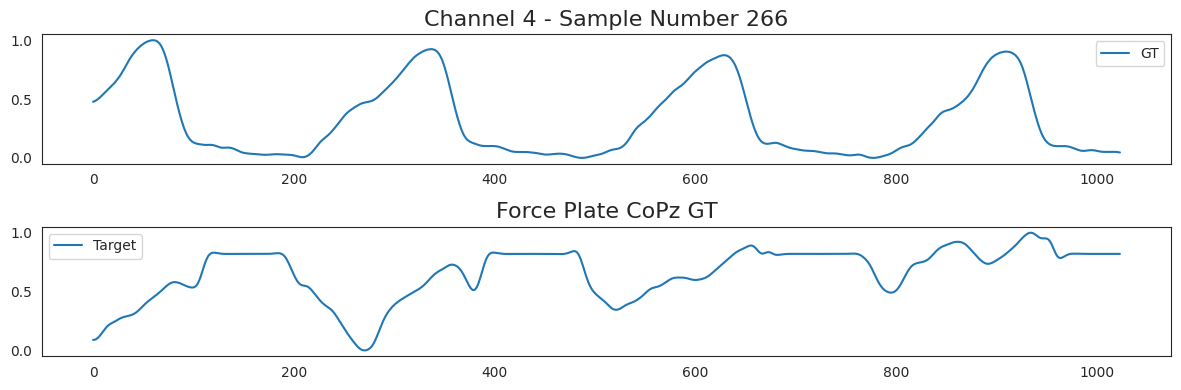

In [9]:
# Plot
data_shape = X_Data.shape
c = random.randint(0, data_shape[2]-1)
i = random.randint(0, data_shape[0]-1)
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(X_Data[i,:,c], label='GT')
# plt.ylim(0,1)
plt.title(f"Channel {c} - Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(2,1,2)
plt.plot(Y_Data[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

# MAIN

Experimenal Configurations

In [10]:
# Configurations
signal_length = X_Data.shape[1]  # Length of each Segment
model_name = 'IMUNet'  # UNet, UNetPP, etc.
model_depth = 5  # Number of Level in the CNN Model
model_width = 32  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = X_Data.shape[2] # Number of Channels in the Model
D_S = 1  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0  # Turn on BiConvLSTM Block
problem_type = 'Regression'
output_nums = Y_Data.shape[2]  # Number of Class for Classification Problems, always '1' for Regression Problems
is_transconv = True # True: Transposed Convolution, False: UpSampling
feature_number = 1024  # Number of Features to be Extracted, only required if the AutoEncoder Mode is turned on

## Model Specific Configurations
alpha = 1  # Model Width Expansion Parameter, for MultiResUNet only
pooling_type = 'mix' # pooling_type, only for EMARS
cardinality = 5  # Cardinality, only for EMARS
q = 3
t = 1

## Data Configurations
DS_Model_Type = 'UNet' # UNet or UNetPP
## Experimental Configurations8
load_weights = False
max_epoch_stop = 30
max_epoch_lr_change = 10
lr = 5e-4
lr_factor = 0.1
monitor_param = 'loss'  # 'loss' or 'acc' for monitoring

Helper Functions

In [11]:
def prepareTrainDict(batch_data, model_depth, model_name):
    def approximate(inp, w_len):
        ops = tf.keras.layers.AveragePooling1D(pool_size=w_len)(inp)
        return ops

    batch_data = np.array(batch_data)
    Y_Train_dict = {}
    Y_Train_dict['out'] = batch_data
    for i in range(1, (model_depth+1)):
        name = f'level{i}'
        if model_name == 'UNet':
            Y_Train_dict[name] = approximate(batch_data, 2**i)
        elif model_name == 'UNetPP':
            Y_Train_dict[name] = batch_data

    return Y_Train_dict

In [12]:
def overlap_data(X_Data, Y_Data, overlap_ratio, target_segment_length):
    # Input Array Shape
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    original_segment_length = X_Data_Shape[1]
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], X_Data_Shape[2]))
    Y_Data_Reshaped = np.reshape(Y_Data, (X_Data_Shape[0]*X_Data_Shape[1], Y_Data_Shape[2]))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    # Overlap
    offset_amount = np.int_(original_segment_length*(1 - overlap_ratio))
    X_Data_New = np.zeros((30000,target_segment_length,X_Data_Reshaped_Shape[1]))
    Y_Data_New = np.zeros((30000,target_segment_length,Y_Data_Reshaped_Shape[1]))
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
    counter = 0
    for i in range(0,num_segments_approx):
        if (i*offset_amount+target_segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp)-np.min(X_Data_Temp))  # Range Normalization [0 1]
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        Y_Data_Temp = (Y_Data_Temp - np.min(Y_Data_Temp))/(np.max(Y_Data_Temp)-np.min(Y_Data_Temp))
        Y_Data_New[counter,:,:] = Y_Data_Temp
        counter = counter + 1
    X_Data_OVRL = X_Data_New[0:counter,:,:]
    Y_Data_OVRL = Y_Data_New[0:counter,:,:]
    
    return X_Data_OVRL, Y_Data_OVRL

Train Loop

In [ ]:
for fnum in range(start_fold,end_fold + 1):
    print(f'Fold {fnum}')
    print(f'Loading Data...')
    if fnum == 1:
        train_sub_IDs = [4,5,6,7,8,9,10]
        test_sub_IDs = [11,12]
    elif fnum == 2:
        train_sub_IDs = [4,5,6,7,8,11,12]
        test_sub_IDs = [9,10]
    elif fnum == 3:
        train_sub_IDs = [4,5,6,9,10,11,12]
        test_sub_IDs = [7,8]
    elif fnum == 4:
        train_sub_IDs = [4,7,8,9,10,11,12]
        test_sub_IDs = [5,6]
    elif fnum == 5:
        train_sub_IDs = [5,6,7,8,9,10,11,12]
        test_sub_IDs = [4]
    train_Indices = np.where(Y_Label_sub == train_sub_IDs)[0]
    X_Train = np.take(X_Data, train_Indices, axis=0)
    Y_Train = np.take(Y_Data, train_Indices, axis=0)
    test_Indices = np.where(Y_Label_sub == test_sub_IDs)[0]
    X_Test = np.take(X_Data, test_Indices, axis=0)
    Y_Test = np.take(Y_Data, test_Indices, axis=0)
    Y_Test_Sub_Labels = np.take(Y_Label_sub, test_Indices, axis=0)
    Y_Test_Speed_Labels = np.take(Y_Label_speed, test_Indices, axis=0)
    Y_Test_Mode_Labels = np.take(Y_Label_mode, test_Indices, axis=0)
    X_Val = X_Test
    Y_Val = Y_Test
    print(f'Dataset info: ')
    print(X_Train.shape)
    print(Y_Train.shape)
    print(X_Test.shape)
    print(Y_Test.shape)
    print(X_Val.shape)
    print(Y_Val.shape)
    print(Y_Test_Sub_Labels.shape)
    print(Y_Test_Speed_Labels.shape)
    print(Y_Test_Mode_Labels.shape)
    X_Train, Y_Train = overlap_data(X_Train, Y_Train, 0.6, 1024)
    print(X_Train.shape)
    print(Y_Train.shape)
    RawDataPath = 'Train_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Train)
    hf.create_dataset('Y', data=Y_Train)
    hf.close()
    RawDataPath = 'Val_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Val)
    hf.create_dataset('Y', data=Y_Val)
    hf.close()
    RawDataPath = 'Test_Set.h5'
    hf = h5py.File(RawDataPath, 'w')
    hf.create_dataset('X', data=X_Test)
    hf.create_dataset('Y', data=Y_Test)
    hf.create_dataset('ID', data=Y_Test_Sub_Labels)
    hf.create_dataset('SPD', data=Y_Test_Speed_Labels)
    hf.create_dataset('MD', data=Y_Test_Mode_Labels)
    hf.close()
    print(f'Building Model...')
    # Build model for PPG2ABP Segmentation - Deep UNet Architecture
    IMU2VGRF_Network = MLMRSNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', output_nums=output_nums,
                                ds=D_S, ae=A_E, cardinality=cardinality, pooling_type=pooling_type).IMUNet()
    # print(IMU2VGRF_Network.summary())
    print(f'Starting Training...')
    if D_S == 0:  # Deep Supervision OFF
        # Compile Built Model
        IMU2VGRF_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(reduction='sum_over_batch_size', name='mean_absolute_error'), 
                                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                                metrics=[tf.keras.metrics.MeanSquaredError(name='mean_squared_error', dtype=None)])
        # Directory for Saving Trained Models
        save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
        # Load Pretrained Weights (if available)
        if (os.path.exists(save_directory) and load_weights == True):
            print('\nLoading Pretrained Weights...')
            # Load Previously Trained Weights for Transfer Learning
            IMU2VGRF_Network.load_weights(save_directory)
        # Declare Callbacks
        if monitor_param == 'loss':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=max_epoch_stop, 
                                                        mode='min'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='min'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_loss', 
                                                        save_best_only=True,
                                                        mode='min')]
        elif monitor_param == 'acc':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                                        patience=max_epoch_stop, 
                                                        mode='max'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='max'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_acc', 
                                                        save_best_only=True, 
                                                        mode='max'),
                        tf.keras.callbacks.TerminateOnNaN()]
        # Train Model
        model_history = IMU2VGRF_Network.fit(X_Train, 
                                            Y_Train, 
                                            epochs=500, 
                                            batch_size=8, 
                                            verbose=1, 
                                            validation_data=(X_Val, Y_Val), 
                                            shuffle=True, 
                                            callbacks=callbacks)
        # Test and Evaluation
        print(f'Evaluating on the Test Set...')
        Y_Pred = IMU2VGRF_Network.predict(X_Test, verbose=0)
        # Save History
        '''print('\n')
        print('Save History')
        # Get the dictionary containing each metric and the loss for each epoch
        history_dict = model_history.history
        history_path = f'History/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}_History.h5'
        json.dump(history_dict.item(), open(history_path, 'w'))
        print('\n')'''
        # Save Outcomes
        print(f'Saving Results...')
        File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fnum}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
        File.create_dataset('X_Test', data=X_Test)
        File.create_dataset('Y_Test', data=Y_Test)
        File.create_dataset('Y_Pred', data=Y_Pred)
        File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
        File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
        File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
        File.close()
        print('\n')
    elif D_S == 1:  # Deep Supervision ON
        # Prepare Train and Test Sets for Deep Supervision
        Y_Train_dict = prepareTrainDict(Y_Train, model_depth, DS_Model_Type)
        Y_Val_dict = prepareTrainDict(Y_Val, model_depth, DS_Model_Type)
        # Generate Custom Loss Weights for Deep Supervision
        loss_weights = {}
        keys = Y_Train_dict.keys()
        k = 0
        for key in keys:
            loss_weights[key] = 1-(k*0.1)
            k = k + 1
        #
        metrics_dic = []
        for i in range(0, model_depth + 1):
            metrics_dic.append(tf.keras.metrics.MeanSquaredError(name='mean_squared_error'))
        #
        losses_dic = []
        for i in range(0, model_depth + 1):
            losses_dic.append(tf.keras.losses.Huber(delta=1.0, 
                                                    reduction='sum_over_batch_size', 
                                                    name='huber_loss'))
        # Compile Built Model
        IMU2VGRF_Network.compile(loss=losses_dic, 
                                optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                                metrics=metrics_dic, 
                                loss_weights=loss_weights)
        # Directory for Saving Trained Models
        save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
        # Load Pretrained Weights (if available)
        if (os.path.exists(save_directory) and load_weights == True):
            print('Loading Pretrained Weights...')
            # Load Previously Trained Weights for Transfer Learning
            IMU2VGRF_Network.load_weights(save_directory)
        # Declare Callbacks
        if monitor_param == 'loss':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', 
                                                        patience=max_epoch_stop, 
                                                        mode='min'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_loss', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='min'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_out_loss', 
                                                        save_best_only=True, 
                                                        mode='min')]
        elif monitor_param == 'acc':
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_acc', 
                                                        patience=max_epoch_stop, 
                                                        mode='max'),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_acc', 
                                                            factor=lr_factor, 
                                                            patience=max_epoch_lr_change, 
                                                            verbose=1, 
                                                            mode='max'),
                        tf.keras.callbacks.ModelCheckpoint(save_directory, 
                                                        verbose=1, 
                                                        monitor='val_out_acc', 
                                                        save_best_only=True, 
                                                        mode='max'),
                        tf.keras.callbacks.TerminateOnNaN()]
        # Train Model
        model_history = IMU2VGRF_Network.fit(X_Train, 
                                            Y_Train_dict, 
                                            epochs=500, 
                                            batch_size=16, 
                                            verbose=1, 
                                            validation_data=(X_Val, Y_Val_dict), 
                                            shuffle=True, 
                                            callbacks=callbacks)
        # Test and Evaluation
        print(f'Evaluating on the Test Set...')
        Y_Pred = IMU2VGRF_Network.predict(X_Test, verbose=0)
        Y_Pred = Y_Pred[-1]
        # Save Outcomes
        print(f'Saving Results...')
        File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fnum}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
        File.create_dataset('X_Test', data=X_Test)
        File.create_dataset('Y_Test', data=Y_Test)
        File.create_dataset('Y_Pred', data=Y_Pred)
        File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
        File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
        File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
        File.close()
    print(f'Delecting Fold {fnum} Data...')
    del IMU2VGRF_Network, model_history, X_Train, Y_Train, X_Test, Y_Test, X_Val, Y_Val, train_Indices, test_Indices
    del Y_Test_Sub_Labels, Y_Test_Speed_Labels, Y_Test_Mode_Labels, Y_Pred, Y_Train_dict, Y_Val_dict, File, hf
    gc.collect()
    print('\n')

Evaluate outside the training loop (if not saved normally)

In [ ]:
fold_num = 1
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test)
File.create_dataset('Y_Test', data=Y_Test)
File.create_dataset('Y_Pred', data=Y_Pred)
File.create_dataset('sub_labels', data=Y_Test_Sub_Labels)
File.create_dataset('speed_labels', data=Y_Test_Speed_Labels)
File.create_dataset('mode_labels', data=Y_Test_Mode_Labels)
File.close()

In [ ]:
num_channels = 6
fold_num = 5
count_samples = 0
X_Test_TOT = np.empty((5000,1024,num_channels))
Y_Test_TOT = np.empty((5000,1024,1))
Y_Pred_TOT = np.empty((5000,1024,1))
sub_labels_TOT = np.empty((5000,1))
speed_labels_TOT = np.empty((5000,1))
mode_labels_TOT = np.empty((5000,1))
for i in range(1, fold_num+1):
    # Load Ground Truth and Results
    print(f'Fold No.: {i}')
    fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_F{i}_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
    # print(fl_Data.keys())
    X_Test_PF = np.array(fl_Data['X_Test'])
    Y_Test_PF = np.array(fl_Data['Y_Test'])
    Y_Pred_PF = np.array(fl_Data['Y_Pred'])
    sub_labels_PF = np.array(fl_Data['sub_labels'])
    speed_labels_PF = np.array(fl_Data['speed_labels'])
    mode_labels_PF = np.array(fl_Data['mode_labels'])
    Evaluation_Metrics(Y_Test_PF, Y_Pred_PF, sub_labels_PF, weight_array)
    num_samples_pf = Y_Test_PF.shape[0]
    print(num_samples_pf)
    X_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = X_Test_PF
    Y_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Test_PF
    Y_Pred_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Pred_PF
    sub_labels_TOT[count_samples:count_samples+num_samples_pf,:] = sub_labels_PF
    speed_labels_TOT[count_samples:count_samples+num_samples_pf,:] = speed_labels_PF
    mode_labels_TOT[count_samples:count_samples+num_samples_pf,:] = mode_labels_PF
    count_samples = count_samples + num_samples_pf
X_Test_TOT = np.array(X_Test_TOT[0:count_samples,:,:])
Y_Test_TOT = np.array(Y_Test_TOT[0:count_samples,:,:])
Y_Pred_TOT = np.array(Y_Pred_TOT[0:count_samples,:,:])
sub_labels_TOT = np.array(sub_labels_TOT[0:count_samples,:])
speed_labels_TOT = np.array(speed_labels_TOT[0:count_samples,:])
mode_labels_TOT = np.array(mode_labels_TOT[0:count_samples,:])
print(X_Test_TOT.shape)
print(Y_Test_TOT.shape)
print(Y_Pred_TOT.shape)
print(sub_labels_TOT.shape)
print(speed_labels_TOT.shape)
print(mode_labels_TOT.shape)
Evaluation_Metrics(Y_Test_TOT, Y_Pred_TOT, sub_labels_TOT, weight_array)
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test_TOT)
File.create_dataset('Y_Test', data=Y_Test_TOT)
File.create_dataset('Y_Pred', data=Y_Pred_TOT)
File.create_dataset('sub_labels', data=sub_labels_TOT)
File.create_dataset('speed_labels', data=speed_labels_TOT)
File.create_dataset('mode_labels', data=mode_labels_TOT)
File.close()
print('\n')

In [ ]:
# Load Ground Truth and Results
fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch25_DS1_F1_combined_insole_FP_Fx_LL.h5'), 'r')
print(fl_Data.keys())
X_Test = np.array(fl_Data['X_Test'])
Y_Test = np.array(fl_Data['Y_Test'])
Y_Pred = np.array(fl_Data['Y_Pred'])
print(X_Test.shape)
print(Y_Test.shape)
print(Y_Pred.shape)

## Evaluate

Error and Correlation Functions

In [13]:
weight_array = {'4': 75.2, 
                '5': 65.1, 
                '6': 56.0, 
                '7': 80.8, 
                '8': 61.5, 
                '9': 81.0, 
                '10': 61.6, 
                '11': 62.4, 
                '12': 69.0}

In [14]:
def Calculate_JEOI(GRND, Pred):
    JEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        JEOI_Temp = EO_Temp_TOT/(EO_Temp_TOT+EE_Temp_TOT+EM_Temp_TOT)
        JEOI.append(JEOI_Temp)
    JEOI_OVR = round(np.mean(JEOI), 5)
    return JEOI_OVR

In [15]:
def Calculate_DEOI(GRND, Pred):
    DEOI = []
    for i in range(GRND.shape[0]):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        # EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        # EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        # EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        DEOI_Temp = (2*EO_Temp_TOT)/((2*EO_Temp_TOT)+EE_Temp_TOT+EM_Temp_TOT)
        DEOI.append(DEOI_Temp)
    DEOI_OVR = round(np.mean(DEOI), 5)
    return DEOI_OVR

In [16]:
def Evaluation_Metrics(Grnd, Pred, Sub_Arr, Weight_Dict):
    mae_err = []
    mse_err = []
    rmse_err = []
    nrmse_err = []
    pcc = []
    r2c = []
    cs = []
    dsc_ = Calculate_DEOI(Grnd, Pred)
    iou_ = Calculate_JEOI(Grnd, Pred)
    if len(Sub_Arr.shape) == 2:
        Sub_Arr = Sub_Arr[:,0]
    for i in range(0,len(Grnd)):
        grnd_current_sample_norm = Grnd[i].ravel()
        pred_current_sample_norm = Pred[i].ravel()
        current_sample_sub_num = np.int_(np.array(Sub_Arr[i]))
        current_sub_weight = Weight_Dict[str(current_sample_sub_num)]
        grnd_current_sample_denorm = grnd_current_sample_norm * current_sub_weight
        pred_current_sample_denorm = pred_current_sample_norm * current_sub_weight
        MAE = np.mean(np.abs(pred_current_sample_denorm - grnd_current_sample_denorm))
        MSE = mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        RMSE = root_mean_squared_error(pred_current_sample_denorm, grnd_current_sample_denorm)
        NRMSE = root_mean_squared_error(pred_current_sample_norm, grnd_current_sample_norm)
        if ~(np.std(grnd_current_sample_norm) == 0 or np.std(pred_current_sample_norm) == 0):
            pcorr, _ = stats.pearsonr(pred_current_sample_norm, grnd_current_sample_norm)
            r2_scr = r2_score(pred_current_sample_norm, grnd_current_sample_norm)
            cs_scr = np.dot(pred_current_sample_norm,grnd_current_sample_norm)/(np.linalg.norm(pred_current_sample_norm)*np.linalg.norm(grnd_current_sample_norm))
        else:
            continue
        mae_err.append(MAE)
        mse_err.append(MSE)
        rmse_err.append(RMSE)
        nrmse_err.append(NRMSE)
        pcc.append(pcorr)
        r2c.append(r2_scr)
        cs.append(cs_scr)
    print(f'MAE Error: {round(np.mean(mae_err), 3)} +/- {round(np.std(mae_err), 3)}')
    print(f'MSE Error: {round(np.mean(mse_err), 3)} +/- {round(np.std(mse_err), 3)}')
    print(f'RMSE Error: {round(np.mean(rmse_err), 3)} +/- {round(np.std(rmse_err), 3)}')
    print(f'Normalized RMSE Error: {round(np.mean(nrmse_err), 3)} +/- {round(np.std(nrmse_err), 3)}')
    print(f'R-squared (R²) Score: {round(np.mean(r2c)*100, 3)}% +/- {round(np.std(r2c)*100, 3)}')
    print(f'Pearson Correlation (PCC): {round(np.mean(pcc)*100, 3)}% +/- {round(np.std(pcc)*100, 3)}')
    print(f'Cosine Similarity: {round(np.mean(cs)*100, 3)}% +/- {round(np.std(cs)*100, 3)}')
    print(f'DSC or Dice Score: {round(np.mean(dsc_)*100, 4)}%')
    print(f'IoU or Jaccard Score: {round(np.mean(iou_)*100, 4)}%')

In [ ]:
num_channels = 6
fold_num = 5
count_samples = 0
X_Test_TOT = np.empty((5000,1024,num_channels))
Y_Test_TOT = np.empty((5000,1024,1))
Y_Pred_TOT = np.empty((5000,1024,1))
sub_labels_TOT = np.empty((5000,1))
speed_labels_TOT = np.empty((5000,1))
mode_labels_TOT = np.empty((5000,1))
for i in range(1, fold_num+1):
    # Load Ground Truth and Results
    print(f'Fold No.: {i}')
    fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_F{i}_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
    # print(fl_Data.keys())
    X_Test_PF = np.array(fl_Data['X_Test'])
    Y_Test_PF = np.array(fl_Data['Y_Test'])
    Y_Pred_PF = np.array(fl_Data['Y_Pred'])
    sub_labels_PF = np.array(fl_Data['sub_labels'])
    speed_labels_PF = np.array(fl_Data['speed_labels'])
    mode_labels_PF = np.array(fl_Data['mode_labels'])
    Evaluation_Metrics(Y_Test_PF, Y_Pred_PF, sub_labels_PF, weight_array)
    num_samples_pf = Y_Test_PF.shape[0]
    print(num_samples_pf)
    X_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = X_Test_PF
    Y_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Test_PF
    Y_Pred_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Pred_PF
    sub_labels_TOT[count_samples:count_samples+num_samples_pf,:] = sub_labels_PF
    speed_labels_TOT[count_samples:count_samples+num_samples_pf,:] = speed_labels_PF
    mode_labels_TOT[count_samples:count_samples+num_samples_pf,:] = mode_labels_PF
    count_samples = count_samples + num_samples_pf
X_Test_TOT = np.array(X_Test_TOT[0:count_samples,:,:])
Y_Test_TOT = np.array(Y_Test_TOT[0:count_samples,:,:])
Y_Pred_TOT = np.array(Y_Pred_TOT[0:count_samples,:,:])
sub_labels_TOT = np.array(sub_labels_TOT[0:count_samples,:])
speed_labels_TOT = np.array(speed_labels_TOT[0:count_samples,:])
mode_labels_TOT = np.array(mode_labels_TOT[0:count_samples,:])
print(X_Test_TOT.shape)
print(Y_Test_TOT.shape)
print(Y_Pred_TOT.shape)
print(sub_labels_TOT.shape)
print(speed_labels_TOT.shape)
print(mode_labels_TOT.shape)
Evaluation_Metrics(Y_Test_TOT, Y_Pred_TOT, sub_labels_TOT, weight_array)
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test_TOT)
File.create_dataset('Y_Test', data=Y_Test_TOT)
File.create_dataset('Y_Pred', data=Y_Pred_TOT)
File.create_dataset('sub_labels', data=sub_labels_TOT)
File.create_dataset('speed_labels', data=speed_labels_TOT)
File.create_dataset('mode_labels', data=mode_labels_TOT)
File.close()
print('\n')

In [ ]:
# Plot
data_shape = Y_Test.shape
input_channel = random.randint(0, X_Test.shape[2] - 1)
i = random.randint(0, data_shape[0])
# Construction_Error(Y_Test[i,:,0], Y_Pred[i,:,0])
corr, _ = stats.pearsonr(Y_Test[i,:,0].ravel(), X_Test[i,:,input_channel].ravel())
r2_scr = r2_score(Y_Test[i,:,0].ravel(), X_Test[i,:,input_channel].ravel())
# xcorr = np.mean(signal.correlate(Y_Test[i,:,0].ravel(), X_Test[i,:,input_channel].ravel(), mode='same') / len(Y_Test[i,:,0]))
cosine_similarity = np.dot(Y_Test[i,:,0].ravel(),X_Test[i,:,input_channel].ravel())/(np.linalg.norm(Y_Test[i,:,0].ravel())*np.linalg.norm(X_Test[i,:,input_channel].ravel()))
print(corr)
print(r2_scr)
# print(xcorr)
print(cosine_similarity)
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(X_Test[i,:,2], label='GT')
# plt.ylim(0,1)
plt.title(f"Insole Sample Number {i} - Insole Sensor Number {input_channel}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,2)
plt.plot(Y_Test[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Force Plate {target_quantity} GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,3)
plt.plot(Y_Pred[i,:,0], label='Pred')
# plt.ylim(0,1)
plt.title(f"{target_quantity} Estimated", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [ ]:
Evaluation_Metrics(Y_Test, Y_Pred, Y_Test_Sub_Labels, weight_array)

### Inspect and Combine 5-Fold CV Results

Combine and Save 5-Fold CV Results for Future Analysis and CycleGAN (Restorer Model - Step 2)

In [20]:
num_channels = 16
fold_num = 5
count_samples = 0
X_Test_TOT = np.empty((5000,1024,num_channels))
Y_Test_TOT = np.empty((5000,1024,1))
Y_Pred_TOT = np.empty((5000,1024,1))
sub_labels_TOT = np.empty((5000,1))
speed_labels_TOT = np.empty((5000,1))
mode_labels_TOT = np.empty((5000,1))
for i in range(1, fold_num+1):
    # Load Ground Truth and Results
    print(f'Fold No.: {i}')
    fl_Data = h5py.File(os.path.join(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_F{i}_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
    # print(fl_Data.keys())
    X_Test_PF = np.array(fl_Data['X_Test'])
    Y_Test_PF = np.array(fl_Data['Y_Test'])
    Y_Pred_PF = np.array(fl_Data['Y_Pred'])
    sub_labels_PF = np.array(fl_Data['sub_labels'])
    speed_labels_PF = np.array(fl_Data['speed_labels'])
    mode_labels_PF = np.array(fl_Data['mode_labels'])
    Evaluation_Metrics(Y_Test_PF, Y_Pred_PF, sub_labels_PF, weight_array)
    num_samples_pf = Y_Test_PF.shape[0]
    print(num_samples_pf)
    X_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = X_Test_PF
    Y_Test_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Test_PF
    Y_Pred_TOT[count_samples:count_samples+num_samples_pf,:,:] = Y_Pred_PF
    sub_labels_TOT[count_samples:count_samples+num_samples_pf,:] = sub_labels_PF
    speed_labels_TOT[count_samples:count_samples+num_samples_pf,:] = speed_labels_PF
    mode_labels_TOT[count_samples:count_samples+num_samples_pf,:] = mode_labels_PF
    count_samples = count_samples + num_samples_pf
X_Test_TOT = np.array(X_Test_TOT[0:count_samples,:,:])
Y_Test_TOT = np.array(Y_Test_TOT[0:count_samples,:,:])
Y_Pred_TOT = np.array(Y_Pred_TOT[0:count_samples,:,:])
sub_labels_TOT = np.array(sub_labels_TOT[0:count_samples,:])
speed_labels_TOT = np.array(speed_labels_TOT[0:count_samples,:])
mode_labels_TOT = np.array(mode_labels_TOT[0:count_samples,:])
print(X_Test_TOT.shape)
print(Y_Test_TOT.shape)
print(Y_Pred_TOT.shape)
print(sub_labels_TOT.shape)
print(speed_labels_TOT.shape)
print(mode_labels_TOT.shape)
Evaluation_Metrics(Y_Test_TOT, Y_Pred_TOT, sub_labels_TOT, weight_array)
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test_TOT)
File.create_dataset('Y_Test', data=Y_Test_TOT)
File.create_dataset('Y_Pred', data=Y_Pred_TOT)
File.create_dataset('sub_labels', data=sub_labels_TOT)
File.create_dataset('speed_labels', data=speed_labels_TOT)
File.create_dataset('mode_labels', data=mode_labels_TOT)
File.close()
print('\n')

Fold No.: 1
MAE Error: 5.837 +/- 2.748
MSE Error: 61.506 +/- 54.298
RMSE Error: 7.186 +/- 3.141
Normalized RMSE Error: 0.11 +/- 0.051
R-squared (R²) Score: 70.048% +/- 37.43
Pearson Correlation (PCC): 94.77% +/- 4.35
Cosine Similarity: 99.12% +/- 0.699
DSC or Dice Score: 91.836%
IoU or Jaccard Score: 85.157%
1035
Fold No.: 2
MAE Error: 6.31 +/- 2.792
MSE Error: 65.006 +/- 56.088
RMSE Error: 7.478 +/- 3.014
Normalized RMSE Error: 0.108 +/- 0.049
R-squared (R²) Score: 73.155% +/- 37.626
Pearson Correlation (PCC): 95.699% +/- 3.683
Cosine Similarity: 99.249% +/- 0.764
DSC or Dice Score: 92.19%
IoU or Jaccard Score: 85.794%
1019
Fold No.: 3
MAE Error: 5.634 +/- 2.731
MSE Error: 60.733 +/- 71.206
RMSE Error: 7.053 +/- 3.315
Normalized RMSE Error: 0.101 +/- 0.048
R-squared (R²) Score: 72.49% +/- 34.064
Pearson Correlation (PCC): 93.072% +/- 7.997
Cosine Similarity: 98.886% +/- 1.42
DSC or Dice Score: 92.629%
IoU or Jaccard Score: 86.505%
1035
Fold No.: 4
MAE Error: 6.331 +/- 3.134
MSE Error:

Generate Fy Outputs

In [17]:
print(X_Test.shape)
num_sensors = X_Test.shape[2]
Y_Pred = np.empty((X_Test.shape[0],X_Test.shape[1],1))
for i in range(0,X_Test.shape[0]):
    Y_Pred_Temp = np.zeros((X_Test.shape[1],1))
    for ii in range(0,num_sensors):
        Y_Pred_Temp = Y_Pred_Temp + np.expand_dims(X_Test[i,:,ii], axis=1)
    Y_Pred_Temp = (Y_Pred_Temp - np.min(Y_Pred_Temp))/(np.max(Y_Pred_Temp) - np.min(Y_Pred_Temp))
    Y_Pred[i,:,:] = Y_Pred_Temp
print(Y_Pred.shape)

(562, 1024, 25)
(562, 1024, 1)


Save Fy Outputs

In [18]:
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_{model_depth}_{model_width}_Ch{num_channel}_DS{D_S}_F{fold_num}_{movement_type}_{target_quantity}_{body_side}.h5', 'w')
File.create_dataset('X_Test', data=X_Test)
File.create_dataset('Y_Test', data=Y_Test)
File.create_dataset('Y_Pred', data=Y_Pred)
File.create_dataset('sub_labels', data=sub_labels)
File.create_dataset('speed_labels', data=speed_labels)
File.create_dataset('mode_labels', data=mode_labels)
File.close()
print('\n')

Save Results




### Detailed Assessment

Load Configurations

In [58]:
target_quantity = 'CoPz'
body_side = 'RL'
model = 'IMUNet'
num_channels = 6
channel_info = '10_90'
movement_type = 'combined_insole_FP_10_90'

Load Results

In [59]:
data = h5py.File(os.path.join(f'Results/Insole2FP_3DGRFM_CoP/{body_side}/{channel_info}/IMUNet_5_32_Ch{num_channels}_DS1_{movement_type}_{target_quantity}_{body_side}.h5'), 'r')
X_Test = data['X_Test']
Y_Test = data['Y_Test']
Y_Pred = data['Y_Pred']
sub_labels = data['sub_labels']
speed_labels = data['speed_labels']
mode_labels = data['mode_labels']
print(X_Test.shape)
print(Y_Test.shape)
print(Y_Pred.shape)
print(sub_labels.shape)
print(speed_labels.shape)
print(mode_labels.shape)

(4737, 1024, 6)
(4737, 1024, 1)
(4737, 1024, 1)
(4737, 1)
(4737, 1)
(4737, 1)


Overall outcome

In [60]:
Evaluation_Metrics(Y_Test, Y_Pred, sub_labels, weight_array)

MAE Error: 7.228 +/- 2.803
MSE Error: 89.16 +/- 68.957
RMSE Error: 8.912 +/- 3.121
Normalized RMSE Error: 0.132 +/- 0.047
R-squared (R²) Score: 57.554% +/- 45.161
Pearson Correlation (PCC): 88.338% +/- 9.824
Cosine Similarity: 98.097% +/- 1.695
DSC or Dice Score: 90.373%
IoU or Jaccard Score: 82.707%


Modewise Result (Walk or Run)

In [ ]:
mode_IDs = np.int_(np.unique(mode_labels))
for i in range(0,len(mode_IDs)):
    current_mode_ID = mode_IDs[i]
    current_mode_indices = np.where(mode_labels == current_mode_ID)[0]
    current_mode_X_Test = np.take(X_Test, current_mode_indices, axis=0)
    current_mode_Y_Test = np.take(Y_Test, current_mode_indices, axis=0)
    current_mode_Y_Pred = np.take(Y_Pred, current_mode_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_mode_indices, axis=0))
    print(f'Mode ID: {current_mode_ID}')
    Evaluation_Metrics(current_mode_Y_Test, current_mode_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

Subjectwise Result

In [25]:
sub_IDs = np.int_(np.unique(sub_labels))
for i in range(0,len(sub_IDs)):
    current_sub_ID = sub_IDs[i]
    current_sub_indices = np.where(sub_labels == current_sub_ID)[0]
    current_sub_X_Test = np.take(X_Test, current_sub_indices, axis=0)
    current_sub_Y_Test = np.take(Y_Test, current_sub_indices, axis=0)
    current_sub_Y_Pred = np.take(Y_Pred, current_sub_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_sub_indices, axis=0))[:,0]
    print(f'Sub ID: {current_sub_ID}')
    Evaluation_Metrics(current_sub_Y_Test, current_sub_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

Sub ID: 4
MAE Error: 9.723 +/- 3.695
MSE Error: 144.28 +/- 103.497
RMSE Error: 11.279 +/- 4.132
Normalized RMSE Error: 0.15 +/- 0.055
R-squared (R²) Score: 46.891% +/- 43.757
Pearson Correlation (PCC): 92.576% +/- 4.499
Cosine Similarity: 98.058% +/- 1.621
DSC or Dice Score: 87.184%
IoU or Jaccard Score: 77.68%

Sub ID: 5
MAE Error: 4.195 +/- 1.924
MSE Error: 30.908 +/- 27.724
RMSE Error: 5.145 +/- 2.106
Normalized RMSE Error: 0.079 +/- 0.032
R-squared (R²) Score: 81.927% +/- 21.144
Pearson Correlation (PCC): 96.139% +/- 4.007
Cosine Similarity: 99.241% +/- 0.855
DSC or Dice Score: 93.214%
IoU or Jaccard Score: 87.497%

Sub ID: 6
MAE Error: 4.428 +/- 1.971
MSE Error: 32.389 +/- 28.469
RMSE Error: 5.26 +/- 2.172
Normalized RMSE Error: 0.094 +/- 0.039
R-squared (R²) Score: 76.447% +/- 24.792
Pearson Correlation (PCC): 95.835% +/- 3.848
Cosine Similarity: 99.273% +/- 1.016
DSC or Dice Score: 93.104%
IoU or Jaccard Score: 87.242%

Sub ID: 7
MAE Error: 8.26 +/- 4.588
MSE Error: 123.756 +/- 

Speedwise Results

In [ ]:
speed_IDs = np.int_(np.unique(speed_labels))
for i in range(0,len(speed_IDs)):
    current_speed_ID = speed_IDs[i]
    current_speed_indices = np.where(speed_labels == current_speed_ID)[0]
    current_speed_X_Test = np.take(X_Test, current_speed_indices, axis=0)
    current_speed_Y_Test = np.take(Y_Test, current_speed_indices, axis=0)
    current_speed_Y_Pred = np.take(Y_Pred, current_speed_indices, axis=0)
    current_mode_sub_labels = np.int_(np.take(sub_labels, current_speed_indices, axis=0))[:,0]
    print(f'Speed ID: {current_speed_ID}')
    Evaluation_Metrics(current_speed_Y_Test, current_speed_Y_Pred, current_mode_sub_labels, weight_array)
    print('')

# Computational Cost Analysis

Load Model

In [ ]:
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, 
                      ds=D_S, ae=A_E, ag=A_G, t=t, is_transconv=is_transconv, q=q).UNet3P()
if D_S == 0:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

In [ ]:
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
SMDisAgg_Network.load_weights(save_directory)

In [ ]:
import time
# Load Test Set
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
print(X_Test.shape)
# X_Test = X_Test[0:1,:,:]
# Predict
start_time= time.time() # set the time at which inference started
for i in range (0,39):
    Y_Pred = SMDisAgg_Network.predict(X_Test[i:i+1,:,:], verbose=0)    
stop_time = time.time()
duration = stop_time - start_time
hours = (duration//3600)/39
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))

msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
print (msg, flush=True) # print out inferenceduration time

In [ ]:
import numpy as np

trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.trainable_weights])
non_trainable_params = np.sum([np.prod(v.get_shape()) for v in SMDisAgg_Network.non_trainable_weights])
total_params = trainable_params + non_trainable_params
    
print(trainable_params)
print(non_trainable_params)
print(total_params)

In [ ]:
SMDisAgg_Network.save('my_model.keras')

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass